In [1]:
%load_ext edx_jupyter
%load_ext autoreload
%autoreload 2

The edx_jupyter extension is already loaded. To reload it, use:
  %reload_ext edx_jupyter


In [4]:
%vertica SELECT 'Connected to Vertica'

OPS_WAREHOUSE_PASSWORD: ········


,?column?
0,Connected to Vertica


In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
import bootstrapped.power as bs_power
import datetime

In [6]:
upgrade_deadline = datetime.date(2017, 8, 1)
sample_start_date = upgrade_deadline - datetime.timedelta(days=15)
sample_end_date = sample_start_date + datetime.timedelta(days=6)

print(f'We would start accruing enrollments at {sample_start_date} 00:00:00 UTC and end at {sample_end_date} 23:59:59 UTC.'
      f' We then look at activity starting {sample_start_date} 00:00:00 UTC and'
      f' ending at {upgrade_deadline} 23:59:59 UTC.')

We would start accruing enrollments at 2017-07-17 00:00:00 UTC and end at 2017-07-23 23:59:59 UTC. We then look at activity starting 2017-07-17 00:00:00 UTC and ending at 2017-08-01 23:59:59 UTC.


In [7]:
%%vertica
SET TIME ZONE TO UTC

In [8]:
%%vertica (sample_start_date, sample_end_date, upgrade_deadline)
DROP TABLE IF EXISTS ex_enrollments;
CREATE LOCAL TEMPORARY TABLE ex_enrollments
ON COMMIT PRESERVE ROWS AS
SELECT
    uc.user_id,
    uc.course_id
FROM production.d_user_course AS uc
JOIN business_intelligence.course_master AS c ON c.course_id = uc.course_id
JOIN production.d_course_seat AS cs ON uc.course_id = cs.course_id
JOIN lms_read_replica.user_api_userpreference up ON up.user_id = uc.user_id
WHERE
        uc.first_enrollment_time::DATE BETWEEN :sample_start_date AND :sample_end_date
    AND c.pacing_type = 'self_paced'
    AND c.course_start_date <= :sample_start_date
    AND cs.course_seat_type = 'verified'
    AND cs.course_seat_upgrade_deadline > :upgrade_deadline
    AND up.key='pref-lang'
    AND up.value='en'

In [9]:
%%vertica
SELECT
    uc.first_enrollment_time :: DATE,
    COUNT(*)
FROM ex_enrollments AS ex
JOIN production.d_user_course AS uc
    ON uc.course_id = ex.course_id
    AND uc.user_id = ex.user_id
GROUP BY 1
ORDER BY 1


,first_enrollment_time,COUNT
0,2017-07-17,14837
1,2017-07-18,16214
2,2017-07-19,15791
3,2017-07-20,17044
4,2017-07-21,15555
5,2017-07-22,11242
6,2017-07-23,11808


In [10]:
%%vertica (test_start_date=sample_start_date, test_end_date=upgrade_deadline) -> engagement
SELECT
    e.user_id,
    e.course_id,
    SUM(COALESCE(act.cnt_engaged_activity, 0)) AS cnt_engaged_activity
FROM
    ex_enrollments e
LEFT JOIN business_intelligence.activity_engagement_user_daily act
    ON e.course_id = act.course_id AND e.user_id = act.user_id AND act.date BETWEEN :test_start_date AND :test_end_date
GROUP BY 1, 2

In [11]:
len(engagement)

102028

Effective power: 0.86
% of Confidence Intervals that contain the true effect size: 0.9
stat_identity
stat_identity


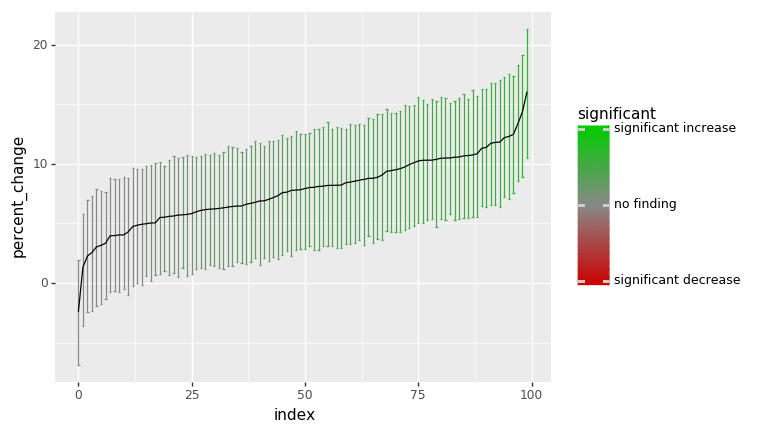

<ggplot: (8750208201704)>

In [25]:
import edx_stats
import edx_plot
from plotnine import *

effect_size = 0.08

results = edx_stats.estimate_power(
    baseline=engagement.cnt_engaged_activity,
    lift=effect_size,
    treatment_size=30000,
    pwr_iterations=100,
    bs_iterations=1000,
    discrete=False,
    variations=3,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

In [14]:
%%vertica (test_start_date=sample_start_date, test_end_date=upgrade_deadline) -> conversion
SELECT
    e.user_id,
    e.course_id,
    CASE
        WHEN duc.first_verified_enrollment_time IS NOT NULL
        THEN TRUE
        ELSE FALSE
    END AS converted,
    CASE
        WHEN duc.first_verified_enrollment_time IS NOT NULL
        THEN COALESCE(cm.course_seat_price, 0)
        ELSE 0
    END AS bookings
FROM
    ex_enrollments e
JOIN business_intelligence.course_master cm
    ON e.course_id = cm.course_id
LEFT JOIN production.d_user_course duc
    ON  e.course_id = duc.course_id
    AND e.user_id = duc.user_id
    AND duc.first_verified_enrollment_time BETWEEN :test_start_date AND :test_end_date

Effective power: 0.83
% of Confidence Intervals that contain the true effect size: 0.9
stat_identity
stat_identity


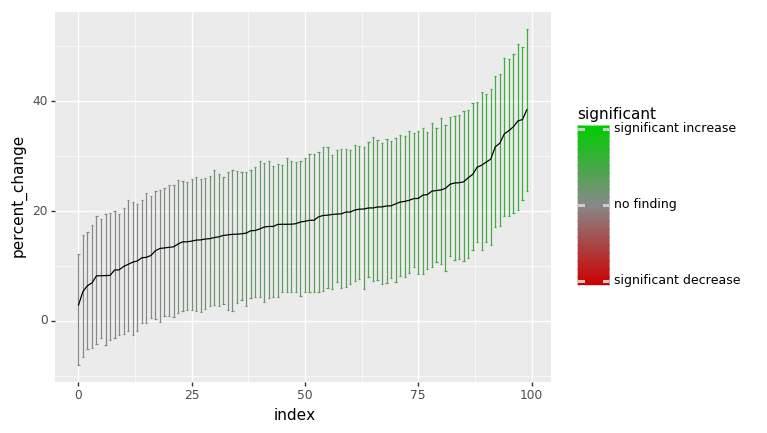

<ggplot: (-9223363286645584745)>

In [28]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=0.18

results = edx_stats.estimate_power(
    baseline=conversion.converted,
    lift=effect_size,
    treatment_size=30000,
    pwr_iterations=100,
    bs_iterations=1000,
    discrete=True,
    variations=3,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)

Effective power: 0.835
% of Confidence Intervals that contain the true effect size: 0.925
stat_identity
stat_identity


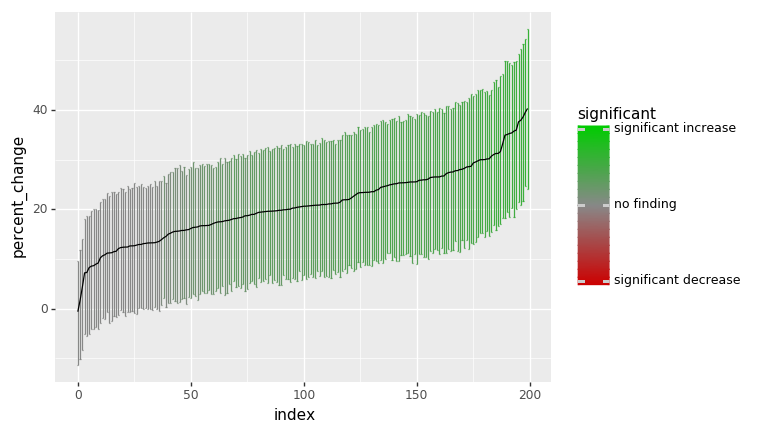

<ggplot: (8750208986951)>

In [32]:
import edx_stats
import edx_plot
from plotnine import *

effect_size=0.20

results = edx_stats.estimate_power(
    baseline=conversion.bookings,
    lift=effect_size,
    treatment_size=30000,
    pwr_iterations=200,
    bs_iterations=1000,
    discrete=True,
    variations=3,
)

display(
    ggplot(
        results,
        aes(x='index',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5
        )
    )
    + edx_plot.geom_power()
)